<font size="8"> **Plotting results from species distribution models for crabeaters seals** </font>  
We will plot the crabeater seal distribution as predicted by four different species distribution model algorithms:  
1. Generalised Additive Models (GAMs)  
2. Maximum Entrophy Modeling (Maxent)  
3. Random Forests (RFs)  
4. Boosted Regression Trees (BRTs)
  
Additionally, an ensemble prediction is included. The ensemble result is simply the mean probability of the four algorithms listed above.

Given the reported influence on crabeater distribution, plots will include the following information:
- Mean sea ice extent (only the edge will be shown)  
- Continental shelf 1,000 m depth contour around the Antarctic continent)  
- Mean position of the southern boundary of the Antarctic Circumpolar Current (ACC)  
  
Distributions are plotted separately for November and December because environmental conditions differ between these two months, and because they represent two different life stages for crabeaters: breeding period (November) and post-breeding (December).

# Loading libraries

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))
#Data manipulation and analysis
import xarray as xr
import pandas as pd
import numpy as np
from itertools import cycle
#Spatial data
import geopandas as gp
#Data visualisation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import string
#Accessing model data
import cosima_cookbook as cc
#Collection of useful functions developed for this project
import UsefulFunctions as uf
#Dealing with paths to folders/files
from glob import glob
#Parallelising work
from dask.distributed import Client

# Loading Indian sectors mask
Since our area of interest includes the East and Central Indian sectors, we will apply a mask to the data prior to calculating the mean for each variable.

0.3.0


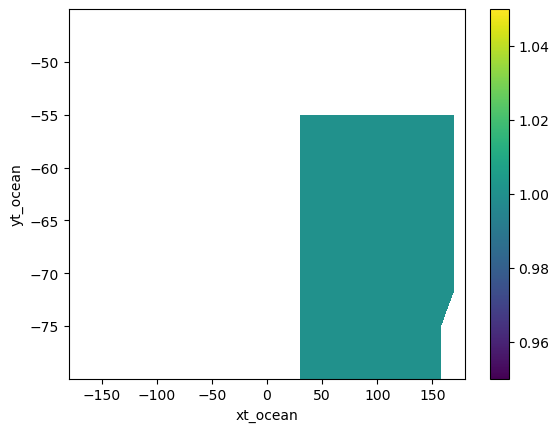

In [2]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))
#Subsetting both masks
measo_ind = xr.where((measo >= 13) & (measo <= 19) & (measo.yt_ocean <= -55), 1, np.nan)
#Checking results
measo_ind.plot()

# Defining output folder

In [3]:
out_folder = '/g/data/v45/la6889/Chapter2_Crabeaters/Mean_conditions_plot'

# Creating a session in the COSIMA cookbook

In [56]:
session = cc.database.create_session()

# Accessing sea ice data from ACCESS-OM2-01
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [5]:
client = Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34159/status,
Dashboard: /proxy/34159/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45715,Workers: 7
Dashboard: /proxy/34159/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:37941,Total threads: 2
Dashboard: /proxy/35603/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:39901,


We will now access the model outputs between November 1981 and December 2013 (period of study). For these calculations, we use monthly sea ice concentration outputs from the fourth cycle of ACCESS-OM2-01 (experiment name `01deg_jra55v140_iaf_cycle4`).

In [6]:
#Loading data
var_ice = uf.getACCESSdata_SO('aice_m', '1981-10', '2014-01', freq = '1 monthly', 
                              ses = session, minlat = -80, exp = '01deg_jra55v140_iaf_cycle4',
                              ice_data = True)

#Ensuring data is selected for the time period and area of interest
var_ice = var_ice.sel(time = slice('1981-11', '2013-12'),
                      yt_ocean = slice(-80, -55))

#Transforming longitudes so their range is +/-180 degrees
var_ice = uf.corrlong(var_ice)

#Checking result
var_ice

<xarray.DataArray 'aice_m' (time: 386, yt_ocean: 557, xt_ocean: 3600)>
dask.array<getitem, shape=(386, 557, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1981-11-30T12:00:00 ... 2013-12-31T12:00:00
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

# Calculating mean sea ice extent over study period

In [7]:
#Calculating mean sea ice extent for November and December in East Antarctica
mean_var = var_ice.groupby('time.month').mean('time').sel(month = slice(11, 12)).where(measo_ind == 1, drop = True)
#Checking results
mean_var

<xarray.DataArray 'aice_m' (month: 2, yt_ocean: 557, xt_ocean: 1400)>
dask.array<where, shape=(2, 557, 1400), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
  * month     (month) int64 11 12
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

# Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original `NaN` values from cumulative sums.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

In [8]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(mean_var >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(mean_var))

#Saving results
ice_10.to_netcdf(os.path.join(out_folder, 'mean_sea_ice_extent.nc'))

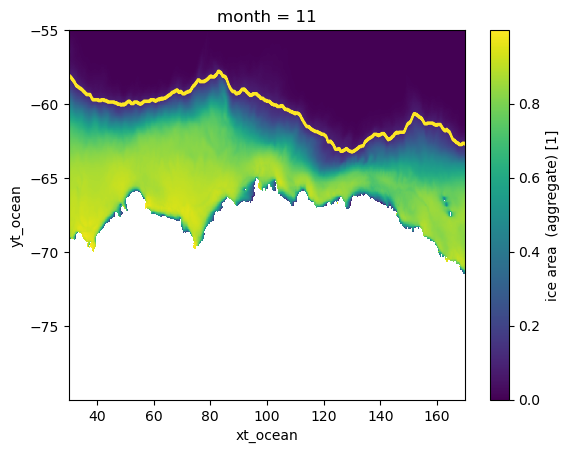

In [9]:
#Checking result for November
mean_var.sel(month = 11).plot()
ice_10.sel(month = 11).plot.contour(levels = [0])

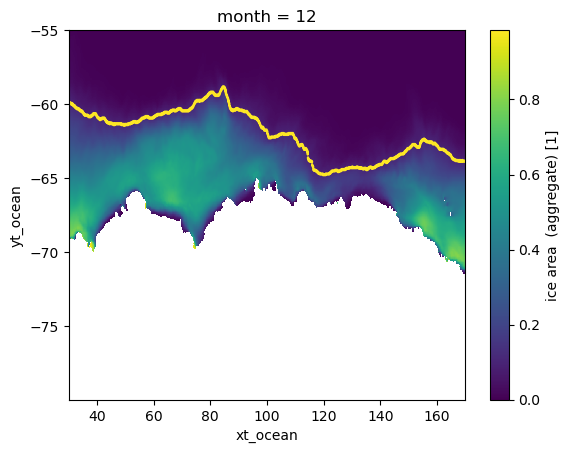

In [10]:
#Checking result for December
mean_var.sel(month = 12).plot()
ice_10.sel(month = 12).plot.contour(levels = [0])

## Loading sea ice edge to avoid calculating again

In [4]:
ice_10 = xr.open_dataarray(os.path.join(out_folder, 'mean_sea_ice_extent.nc'))

# Loading regridded GEBCO bathymetry file
We will load the regridded GEBCO bathymetry that was used to create the bathymetry for the ACCESS-OM2-01 model.

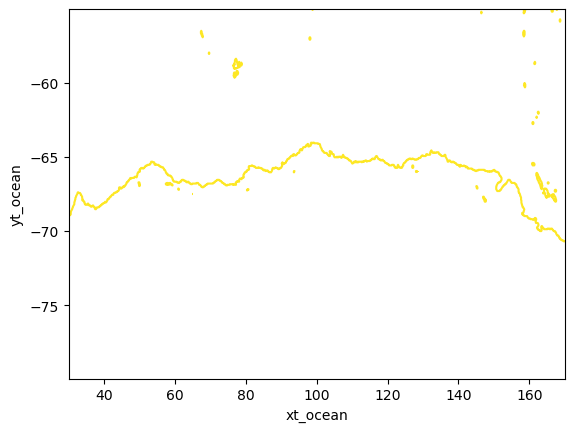

In [57]:
#Loading GEBCO bathymetry
bathy = xr.open_dataarray('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/topog.nc')

#Loading area data from ACCESS model to use as target grid
area = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1)

#Assigning coordinate values to replace indices
bathy.coords['xx'] = area['xt_ocean'].values
bathy.coords['yy'] = area['yt_ocean'].values

#Rename coordinate variables so they match model data and subsetting the Southern Ocean
bathy = bathy.rename(({'xx':'xt_ocean', 'yy':'yt_ocean'})).sel(yt_ocean = slice(-80, -55))

#Ensuring longitude values range between +/-180
bathy = uf.corrlong(bathy).where(measo_ind == 1, drop = True)

#Converting to binaty mask
bathy_1000 = xr.where(bathy <= 1000, 1, 0).where(~np.isnan(bathy))

#Checking results
bathy_1000.plot.contour(levels = [0])

In [ ]:
#Saving results
bathy_1000.to_netcdf(os.path.join(out_folder, 'bathy_1000m.nc'))

## Loading 1000 m depth contour to avoid calculating again

In [5]:
bathy_1000 = xr.open_dataarray(os.path.join(out_folder, 'bathy_1000m.nc'))

# Transform ACCESS-OM2-01 grid to dataframe

In [6]:
area_df = bathy_1000.to_dataframe().reset_index()
area_df.drop(columns = 'depth', inplace = True)
area_df = area_df.round({'yt_ocean': 3, 'xt_ocean': 3})
area_df

,yt_ocean,xt_ocean
0,-79.968,30.05
1,-79.968,30.15
2,-79.968,30.25
3,-79.968,30.35
4,-79.968,30.45
...,...,...
779795,-55.010,169.55
779796,-55.010,169.65
779797,-55.010,169.75
779798,-55.010,169.85


In [7]:
#Getting number of times month has to be repeated
rows_month = area_df.shape[0]

#Bind static variables by row
area_df = pd.concat([area_df, area_df], axis = 0)

#Add a month column to bind data frame
area_df['month'] = [11]*rows_month + [12]*rows_month

#Check results
area_df

,yt_ocean,xt_ocean,month
0,-79.968,30.05,11
1,-79.968,30.15,11
2,-79.968,30.25,11
3,-79.968,30.35,11
4,-79.968,30.45,11
...,...,...,...
779795,-55.010,169.55,12
779796,-55.010,169.65,12
779797,-55.010,169.75,12
779798,-55.010,169.85,12


## Loading weights for model ensemble
Since not all SDMs performed equally well, the final ensemble will be calculated as a weighted mean of the four SDMs used in this project: GAMs, Maxent, BRTs and RFs. The weighting will depend on three model performance metrics: area under the the receiver operating curve ($AUC_{ROC}$), area under the precisison-recall gain curve ($AUC_{PRG}$) and the Pearson correlation between the model predictions and the testing dataset.

In [8]:
model_eval = pd.read_csv('../SDM_outputs/model_evaluation.csv')
model_eval

,model,env_trained,auc_roc,auc_prg,pear_cor,pear_norm_weights
0,GAM,mod_match_obs,0.633070,0.402990,0.103890,0.084357
1,GAM,full_access,0.677447,0.557247,0.142171,0.115531
2,GAM,observations,0.633379,0.374709,0.108059,0.092235
3,Maxent,mod_match_obs,0.648174,0.712805,0.061705,0.000000
4,Maxent,full_access,0.685791,0.862567,0.079396,0.000000
5,Maxent,observations,0.663044,0.540762,0.066842,0.000000
6,RandomForest,mod_match_obs,0.853296,0.852542,0.324360,0.525220
7,RandomForest,full_access,0.947518,0.991557,0.379160,0.551686
8,RandomForest,observations,0.918195,0.972477,0.317180,0.560208
9,BoostedRegressionTrees,mod_match_obs,0.818797,0.833306,0.256950,0.390423


# Predicted distribution ACCESS-OM2-01 matches observations

In [9]:
#Providing location of SDM outputs
mod_match_files = ['../SDM_outputs/GAM/mean_pred_match_obs.csv',
                   '../SDM_outputs/Maxent/Mod_match_obs/reduced_Maxent_model/mean_pred_match_obs.csv', 
                   '../SDM_outputs/RandomForest/Mod_match_obs/mean_pred_match_obs.csv',
                   '../SDM_outputs/BoostedRegressionTrees/Mod_match_obs/mean_pred_match_obs.csv']

#Extracting algorithm name
models = [f.split('/')[2] for f in mod_match_files]

In [11]:
#Loading data frames with predictions
mod_match_obs_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(mod_match_files)]
#Create dataset
mod_match_obs = uf.ds_sdm(mod_match_obs_df, bathy_1000, 
                          model_eval[model_eval.env_trained == 'mod_match_obs'],
                          'pear_norm_weights')
#Saving dataset
mod_match_obs.to_netcdf(os.path.join(out_folder, 'mod_match_obs.nc'))

In [6]:
mod_match_obs = xr.open_dataset(os.path.join(out_folder, 'mod_match_obs.nc'))

## Predicted distribution ACCESS-OM2-01 full suite

In [12]:
mod_files = ['../SDM_outputs/GAM/mean_pred_mod.csv',
             '../SDM_outputs/Maxent/Mod_full/reduced_Maxent_model/mean_pred_ACCESS.csv',
             '../SDM_outputs/RandomForest/Mod_full/mean_pred_ACCESS.csv',
             '../SDM_outputs/BoostedRegressionTrees/Mod_full/mean_pred_ACCESS.csv']

In [13]:
#Loading data frames with predictions
mod_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(mod_files)]
#Create dataset
mod = uf.ds_sdm(mod_df, bathy_1000, model_eval[model_eval.env_trained == 'full_access'],
                'pear_norm_weights')
#Saving dataset
mod.to_netcdf(os.path.join(out_folder, 'full_mod.nc'))

In [50]:
mod = xr.open_dataset(os.path.join(out_folder, 'full_mod.nc'))

## Predicted distribution observations

In [14]:
obs_files = ['../SDM_outputs/GAM/mean_pred_obs.csv',
             '../SDM_outputs/Maxent/Obs/reduced_Maxent_model/mean_pred_obs.csv',
             '../SDM_outputs/RandomForest/Obs/mean_pred_obs.csv',
             '../SDM_outputs/BoostedRegressionTrees/Obs/mean_pred_obs.csv']

In [16]:
#Loading data frames with predictions
obs_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(obs_files)]
#Create dataset
obs = uf.ds_sdm(obs_df, bathy_1000, model_eval[model_eval.env_trained == 'observations'],
                'pear_norm_weights')
#Saving dataset
obs.to_netcdf(os.path.join(out_folder, 'obs.nc'))

In [51]:
obs = xr.open_dataset(os.path.join(out_folder, 'obs.nc'))

## Plotting results

### November predictions

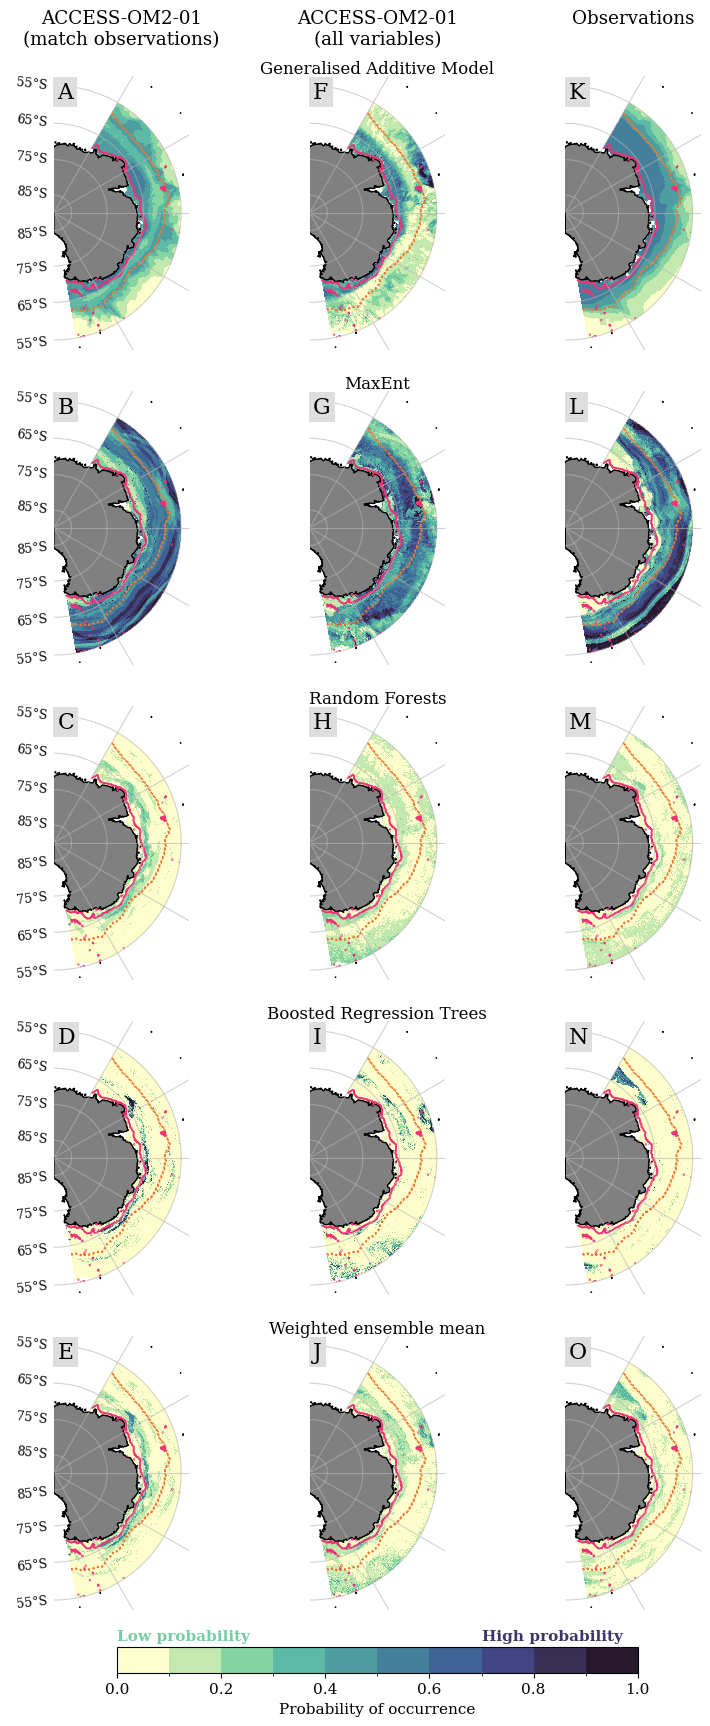

In [17]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [9.6, 24])

#Setting levels for colorbar
levels = np.arange(0, 1.1, 0.1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining SDM algorithms
SDM = ['Generalised Additive Model', 'MaxEnt', 'Random Forests', 'Boosted Regression Trees', 
       'Weighted ensemble mean']

#Defining datasets to be plotted
trained_by = ['ACCESS-OM2-01\n(match observations)', 
              'ACCESS-OM2-01\n(all variables)', 
              'Observations\n']

#Index to loop through each subplot
counter = zip(cycle(np.arange(0, 5)), np.repeat(np.arange(0, 3), 5))

#Create grid
gs = gridspec.GridSpec(nrows = 5, ncols = 3)
#Change the width between each plot
gs.update(wspace = 0.1, hspace = 0.15)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loop
for i, j in counter:
    ax[i, j] = fig.add_subplot(gs[i, j], projection = projection)
    #Select data based on column index
    if j == 0:
        da = mod_match_obs.November
    elif j == 1:
        da = mod.November
    elif j == 2:
        da = obs.November
    #Plot maps
    p1 = da.isel(model = i).plot.pcolormesh(ax = ax[i, j], colors = cm.cm.deep, 
                                            levels = levels, add_colorbar = False,
                                            transform = ccrs.PlateCarree())
    ice_10.sel(month = 11).plot.contour(levels = [0], colors = '#ee7733', linewidths = 1.3,
                                        ax = ax[i, j], linestyles = 'dotted',
                                        transform = ccrs.PlateCarree(),
                                       add_colorbar = False)
    bathy_1000.plot.contour(levels = [0], colors = '#ee3377', ax = ax[i, j], linewidths = 1.3,
                      transform = ccrs.PlateCarree(), add_colorbar = False)

    #Drawing gridlines
    if j == 0:
        gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = True, y_inline = False, 
                                color = "#b4b4b4", alpha = 0.6)
        gl.ylabels_right = False
        gl.xlabels_bottom = False
        gl.ylabel_style = {'size': 9}
        gl.xlabel_style = {'alpha': 0}
    else:
        gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, y_inline = False, 
                                color = "#b4b4b4", alpha = 0.6)

    #Set titles for each map
    if i == 0:
        ax[i, j].set_title(f'{trained_by[j]}\n', y = 1.01)
    if j == 1:
         ax[i, j].text(0.5, 1.025, f'{SDM[i]}', horizontalalignment = 'center', fontsize = 12,
                       verticalalignment = 'center', transform = ax[i, j].transAxes)
    
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i, j].spines.values()]
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])
    
#Add land and coastlines
[ax[a].add_feature(land_50m) for a in ax]
[ax[a].coastlines(resolution = '50m') for a in ax]
#Set extent shown in map
[ax[a].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree()) for a in ax]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.02, 
                  label = 'Probability of occurrence')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(cm.cm.deep)
cb.ax.text(0., 1.25, 'Low probability', color = cmap(0.25), fontweight = 'bold')
cb.ax.text(0.7, 1.25, 'High probability', color = cmap(0.85), fontweight = 'bold')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:15]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.025, .92, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/November_results.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

### December predictions

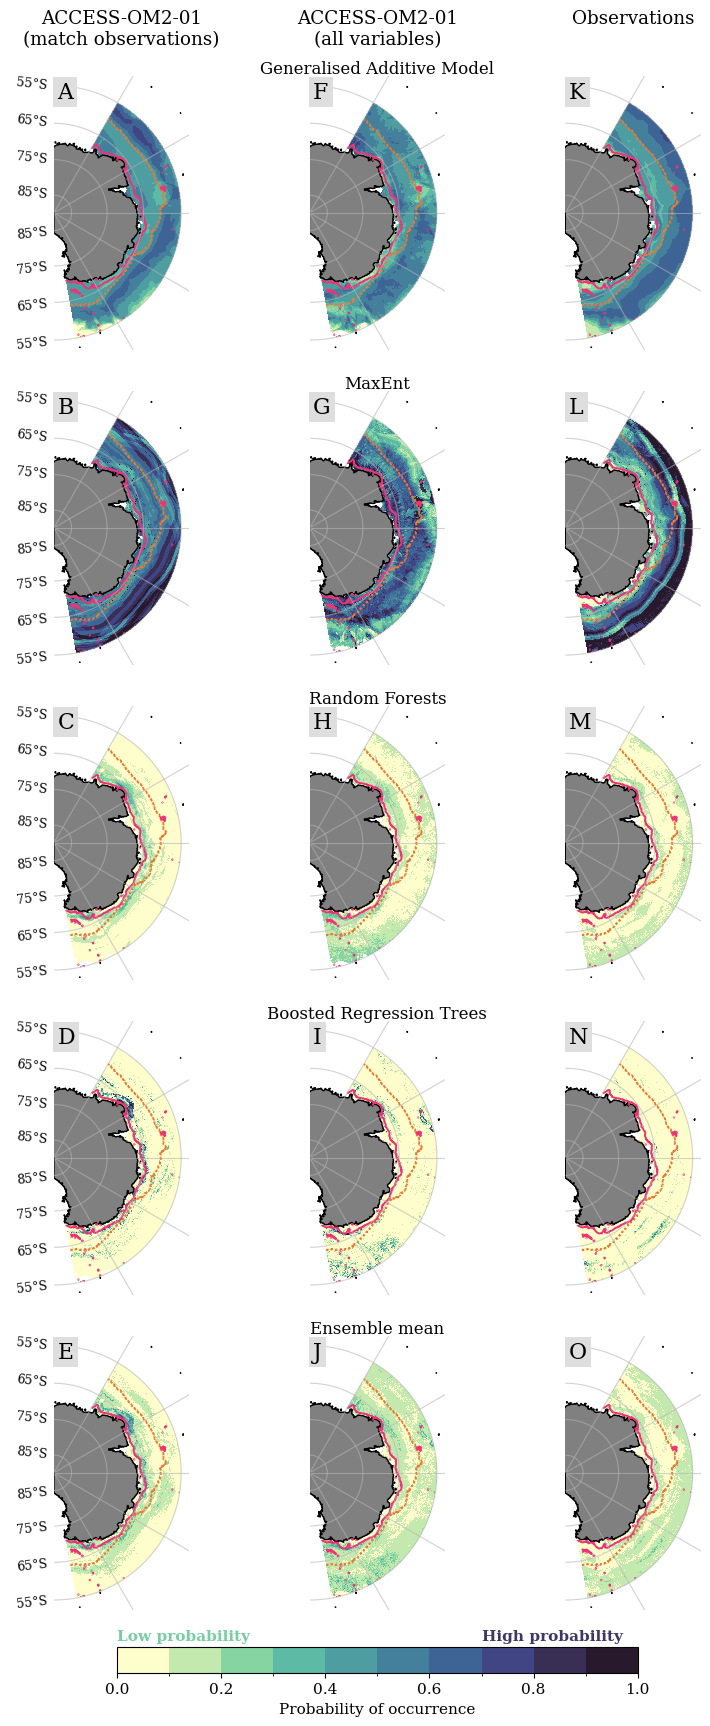

In [18]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [9.6, 24])

#Setting levels for colorbar
levels = np.arange(0, 1.1, 0.1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining SDM algorithms
SDM = ['Generalised Additive Model', 'MaxEnt', 'Random Forests', 'Boosted Regression Trees', 
       'Ensemble mean']

#Defining datasets to be plotted
trained_by = ['ACCESS-OM2-01\n(match observations)', 
              'ACCESS-OM2-01\n(all variables)', 
              'Observations\n']

#Index to loop through each subplot
counter = zip(cycle(np.arange(0, 5)), np.repeat(np.arange(0, 3), 5))

#Create grid
gs = gridspec.GridSpec(nrows = 5, ncols = 3)
#Change the width between each plot
gs.update(wspace = 0.1, hspace = 0.15)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loop
for i, j in counter:
    ax[i, j] = fig.add_subplot(gs[i, j], projection = projection)
    #Select data based on column index
    if j == 0:
        da = mod_match_obs.December
    elif j == 1:
        da = mod.December
    elif j == 2:
        da = obs.December
    #Plot maps
    p1 = da.isel(model = i).plot.pcolormesh(ax = ax[i, j], colors = cm.cm.deep, 
                                            levels = levels, add_colorbar = False,
                                            transform = ccrs.PlateCarree())
    ice_10.sel(month = 12).plot.contour(levels = [0], colors = '#ee7733', linewidths = 1.3,
                                        ax = ax[i, j], linestyles = 'dotted',
                                        transform = ccrs.PlateCarree(),
                                       add_colorbar = False)
    bathy_1000.plot.contour(levels = [0], colors = '#ee3377', ax = ax[i, j], linewidths = 1.3,
                      transform = ccrs.PlateCarree(), add_colorbar = False)

    #Drawing gridlines
    if j == 0:
        gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = True, y_inline = False, 
                                color = "#b4b4b4", alpha = 0.6)
        gl.ylabels_right = False
        gl.xlabels_bottom = False
        gl.ylabel_style = {'size': 9}
        gl.xlabel_style = {'alpha': 0}
    else:
        gl = ax[i, j].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, y_inline = False, 
                                color = "#b4b4b4", alpha = 0.6)

    #Set titles for each map
    if i == 0:
        ax[i, j].set_title(f'{trained_by[j]}\n', y = 1.01)
    if j == 1:
         ax[i, j].text(0.5, 1.025, f'{SDM[i]}', horizontalalignment = 'center', fontsize = 12,
                       verticalalignment = 'center', transform = ax[i, j].transAxes)
    
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i, j].spines.values()]
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])
    
#Add land and coastlines
[ax[a].add_feature(land_50m) for a in ax]
[ax[a].coastlines(resolution = '50m') for a in ax]
#Set extent shown in map
[ax[a].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree()) for a in ax]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.02, 
                  label = 'Probability of occurrence')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(cm.cm.deep)
cb.ax.text(0., 1.25, 'Low probability', color = cmap(0.25), fontweight = 'bold')
cb.ax.text(0.7, 1.25, 'High probability', color = cmap(0.85), fontweight = 'bold')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:15]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.025, .92, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/December_results.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

# Plotting crabeater seals and background locations

## Loading crabeater data

In [8]:
seals = pd.read_csv('../Environmental_Data/mod-match-obs_env_pres_bg_20x_Indian_weaning.csv')
seals

,year,month,xt_ocean,yt_ocean,presence,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,SIC,SST_degC,lt_pack_ice,dist_ice_edge_km
0,1998,11,75.85,-69.113,1,89.937,-492.145,130.290,628.583,0.649964,-1.794739,0.595238,-1007.829786
1,1998,11,75.35,-69.028,1,89.651,-481.137,117.409,729.212,0.681497,-1.801086,0.630952,-996.341423
2,1996,11,76.05,-68.986,1,89.957,-479.088,119.262,771.083,0.630009,-1.641327,0.595238,-945.316770
3,1998,11,75.45,-68.606,1,89.725,-434.549,71.716,657.067,0.777837,-1.816406,0.630952,-950.011791
4,1998,11,75.35,-68.395,1,89.720,-410.830,47.949,578.417,0.949461,-1.854187,0.630952,-926.231709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32363,1989,11,74.05,-59.442,0,89.919,543.100,725.785,1618.292,0.573761,-1.578430,0.000000,-83.181802
32364,1998,11,71.75,-59.238,0,89.976,559.524,720.119,4481.736,0.014074,-0.818604,0.000000,76.604135
32365,1996,11,76.35,-59.238,0,89.961,506.485,705.324,1267.889,0.027897,-0.833191,0.011905,52.081125
32366,1989,11,73.95,-58.827,0,89.971,610.227,790.155,2223.069,0.153407,-1.237152,0.000000,-18.242142


## Loading ocean fronts shapefile

In [48]:
#Ocean fronts in the Southern Ocean
SACC = gp.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/Southern Ocean Fronts/SouthernOceanFronts.shp')
SACC = SACC[SACC.NAME.str.contains('boundary')]

#Define projection to south polar stereographic
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

## Plotting figure

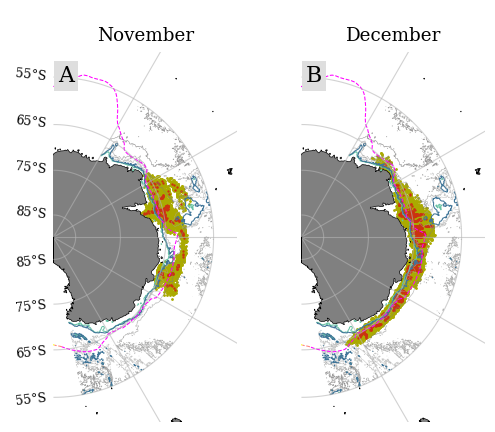

In [134]:
fig = plt.figure()#figsize = [6.4*1.25, 4.8*2], constrained_layout = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11 

#Setting levels for deep depth contours (>2000m)
levels = np.arange(3000, 6000, 1000)

#Colormaps for bathymetry
my_map_s = mcolors.LinearSegmentedColormap.from_list('my_colormap', 
                                                   cm.cm.deep(np.linspace(0.3, 0.6, 128)))
my_map_d = mcolors.LinearSegmentedColormap.from_list('my_colormap', 
                                          cm.cm.gray_r(np.linspace(0.3, 0.6, 128)))

#Creating labels 
months = ['November', 'December']

#Create grid - No space between plots
gs = gridspec.GridSpec(nrows = 1, ncols = 2, wspace = 0)

#Initiliase dictionary to store axes
ax = {}

#First panel - Background points
for i, m in enumerate([11, 12]):
    ax[i] = fig.add_subplot(gs[i], projection = projection)
    #Plot deep areas (>2000 m)
    bathy.plot.contour(ax = ax[i], transform = ccrs.PlateCarree(), 
                            levels = levels, cmap = my_map_d,
                            linewidths = 0.4, alpha = 0.6)
    #Get seal data for month
    mth = seals[(seals.month == m)]
    #Plot background points
    mth[(mth.presence == 0)].plot.scatter(x = 'xt_ocean', y = 'yt_ocean', s = 1,
                                          c = '#aaaa00', ax = ax[i], 
                                          transform = ccrs.PlateCarree())
    #Plot crabeater locations
    mth[(mth.presence == 1)].plot.scatter(x = 'xt_ocean', y = 'yt_ocean', s = 0.5,
                                          c = '#cc3311', ax = ax[i], 
                                          transform = ccrs.PlateCarree())
    #Plot bathymetry contours for shallower areas (1000-200m)
    bathy.plot.contour(ax = ax[i], transform = ccrs.PlateCarree(), 
                            levels = [1000, 2000], cmap = my_map_s, 
                            linewidths = 0.75)

    #Plot southern boundary of ACC
    SACC[SACC.NAME.str.contains('boundary')].plot(ax = ax[i], ls = '--', 
                                                  lw = 0.75, 
                                                  cmap = mpl.colormaps['spring'])
    
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    
    #Keep axis labels on left only
    if i == 0:
        gl = ax[i].gridlines(crs = ccrs.PlateCarree(), draw_labels = True, 
                             y_inline = False, color = "#b4b4b4", alpha = 0.6)
        gl.ylabels_right = False
        gl.xlabels_bottom = False
        gl.ylabel_style = {'size': 9}
        gl.xlabel_style = {'alpha': 0}
    else:
        gl = ax[i].gridlines(crs = ccrs.PlateCarree(), draw_labels = False, 
                             y_inline = False, color = "#b4b4b4", alpha = 0.6)
    gl.ylocator = mticker.FixedLocator([-55, -65, -75, -85])

    #Set titles for each map
    ax[i].set_title(f'{months[i]}', y = 1.01)

    #Add land and coastline
    ax[i].add_feature(land_50m)

    #Set extent shown in map
    ax[i].set_extent([0, 180, -90, -50], crs = ccrs.PlateCarree())

    #Getting the alphabet in upper case to label plots
    labels = string.ascii_uppercase[0:2]
    #Apply labels only to plots, not colorbars
    ax[i].text(0.025, .92, labels[i], transform = ax[i].transAxes, 
               fontsize = 'x-large', bbox = dict(facecolor = '#dedede',
                                                 edgecolor = 'none', pad = 3.0))

#Saving figure
plt.savefig('../SDM_outputs/crabeater_locations_bg-pts.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)